In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import numpy as np
from scipy.signal import wiener
from tqdm import tqdm
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

sys.path.append(str(Path("..").resolve()))
from src import *

# Fourier Transform

In [2]:
FRAMES=300
astro_x_path = DATASETS["oabf_astro"].dir / "x.tiff"
astro_y_path = DATASETS["oabf_astro"].dir / "y.tiff"
astro_x, astro_y = (Recording(_, max_frames=FRAMES) for _ in [astro_x_path, astro_y_path])

In [3]:
fft_x = np.fft.fft(astro_x.np, axis=0)
fft_abs_x = np.abs(fft_x)
fft_angle_x = np.angle(fft_x, deg=True)
del fft_x

In [4]:
fft_y = np.fft.fft(astro_y.np, axis=0)
fft_abs_y = np.abs(fft_y)
fft_angle_y = np.angle(fft_y, deg=True)
del fft_y

In [ ]:
dt = 1 / 7  # Astro is 7Hz
freqs = np.fft.fftfreq(astro_x.np.shape[0], d=dt)
rfft_abs_x = fft_abs_x[freqs >= 0]
rfft_abs_y = fft_abs_y[freqs >= 0]
rfft_angle_x = fft_angle_x[freqs >= 0]
rfft_angle_y = fft_angle_y[freqs >= 0]

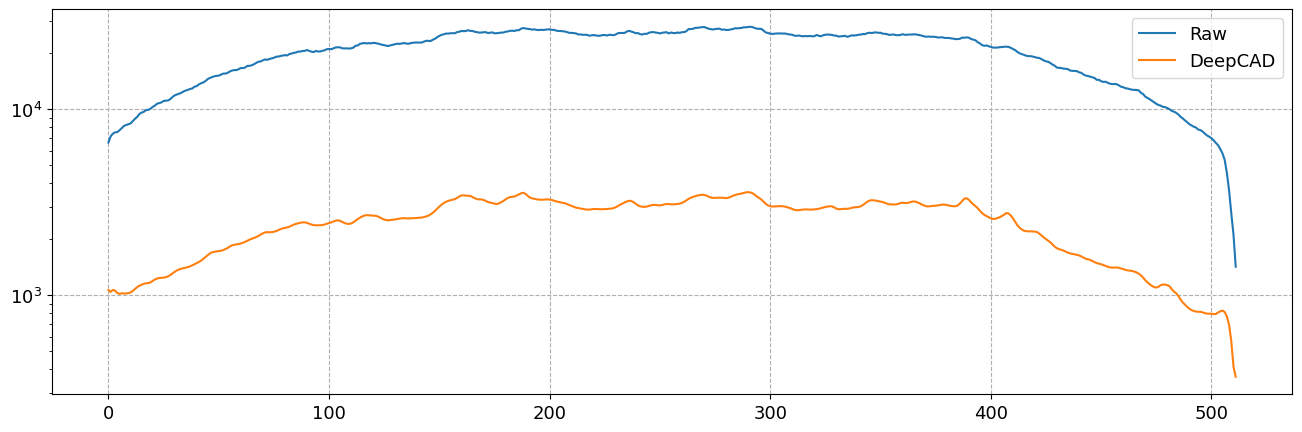

In [ ]:
pd.Series(rfft_abs_x.mean(axis=(0, 1))).plot(figsize=(16, 5), label="Raw")
pd.Series(rfft_abs_y.mean(axis=(0, 1))).plot(figsize=(16, 5), label="DeepCAD")
plt.legend()
plt.yscale("log")

In [ ]:
Recording(rfft_abs_x).render("rfft_abs_x.mp4", bitrate=2000, fps=7)
Recording(rfft_abs_y).render("rfft_abs_y.mp4", bitrate=2000, fps=7)
Editor().compose([{"Raw": "rfft_abs_x.mp4", "DeepCAD": "rfft_abs_y.mp4"}], "rfft_abs_comb.mp4", bitrate=2500)

Frequency= 0.00ω


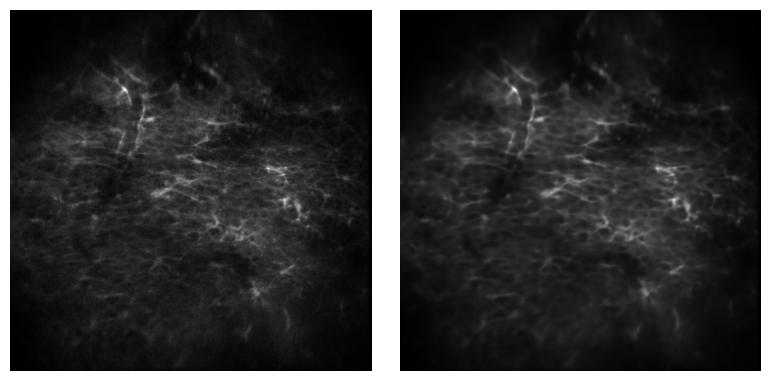

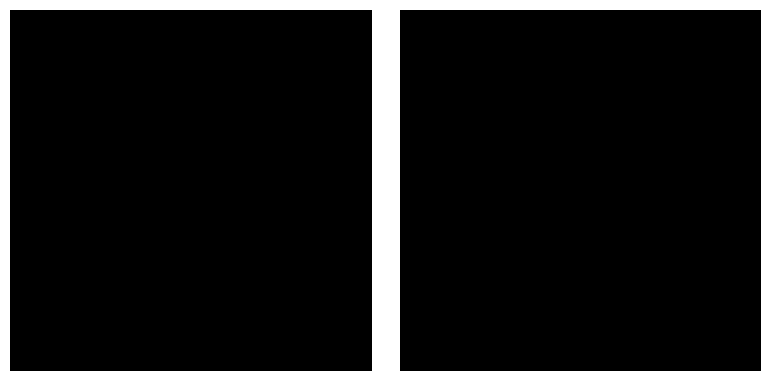

Frequency= 0.02ω


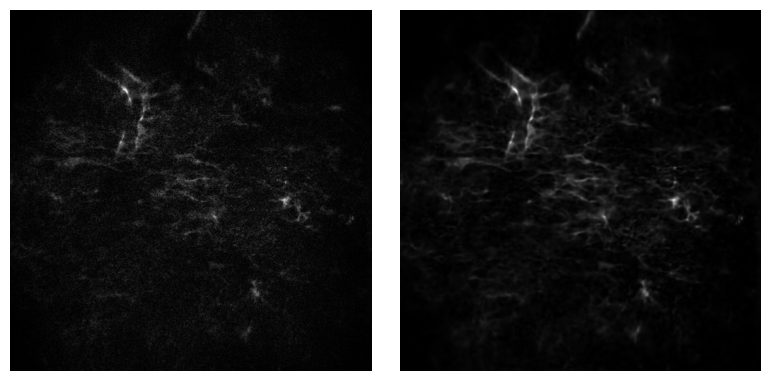

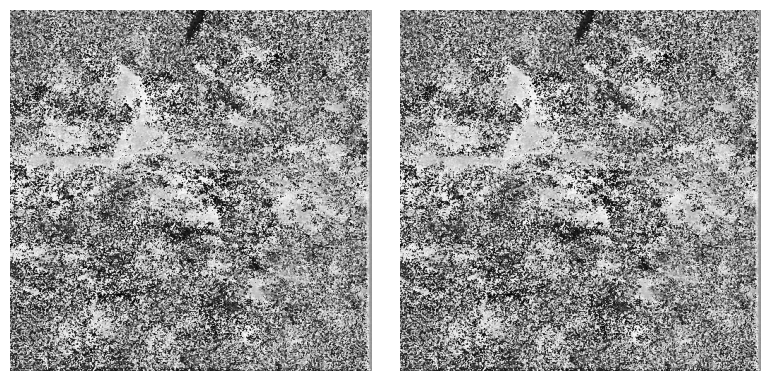

Frequency= 0.05ω


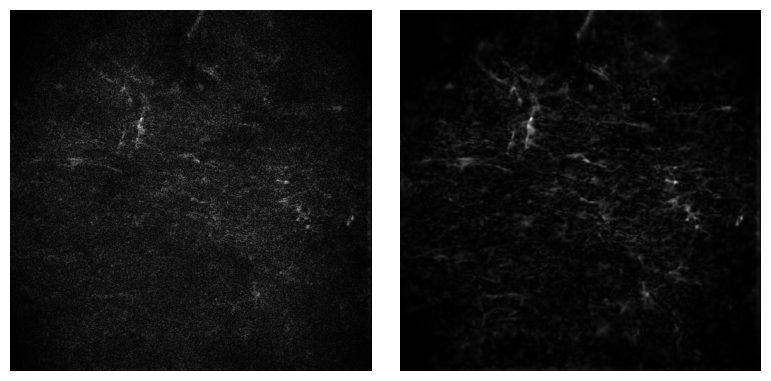

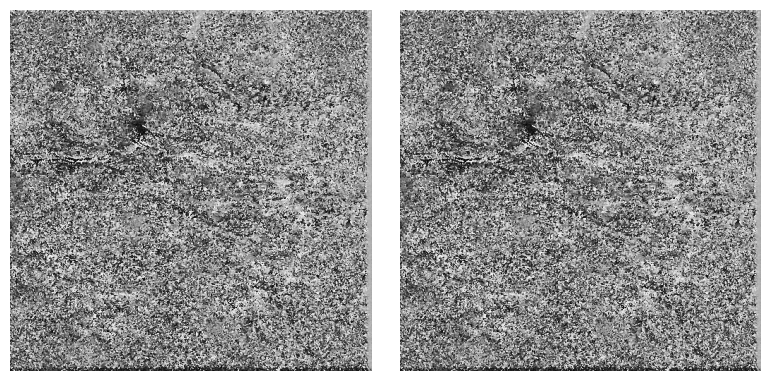

Frequency= 3.48ω


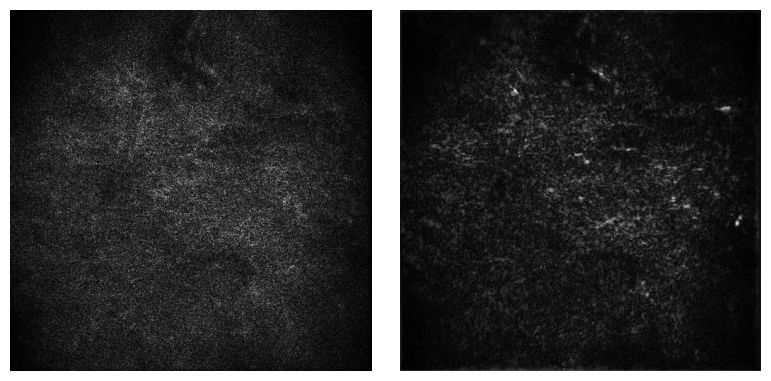

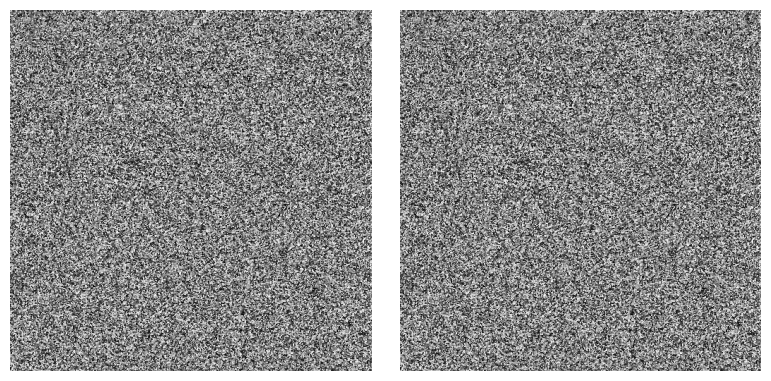

In [73]:
for i in [0, 1, 2, -1]:
    cprint(f"Frequency=", f"cyan:{freqs[freqs>=0][i]:.2f}ω")
    imshow([rfft_abs_x[i], rfft_abs_y[i]])
    imshow([rfft_angle_x[i], rfft_angle_x[i]])

### The magnitude of the lowest-freq frame can be taken from RAW

In [ ]:
np.save(f"{FRAMES}_freq0.npy", fft_abs_x[0])

In [5]:
fft_abs = fft_abs_y
fft_abs[0] = fft_abs_x[0].copy()
del fft_abs_x, fft_angle_x
X = fft_abs_y * np.exp(1j * np.deg2rad(fft_angle_y))
astro_fused = np.fft.ifft(X, axis=0).real

In [8]:
suffx=FRAMES
Recording(astro_fused).render(f"fft_fusion_{suffx}.mp4", fps=30)
# astro_y.render("astro_y.mp4", fps=30)
Editor().alternate(
    {"FFT Fused": f"fft_fusion_{suffx}.mp4", "DeepCAD": "astro_y.mp4"}, f"fft_fusion_{suffx}_alt.mp4", bitrate=3000, delta=1.5
)
Editor().compose([{"FFT Fused": f"fft_fusion_{suffx}.mp4", "DeepCAD": "astro_y.mp4"}], f"fft_fusion_{suffx}_comb.mp4", bitrate=3500)

x265 [info]: HEVC encoder version 3.5+1-f0c1022b6
x265 [info]: build info [Linux][GCC 8.3.0][64 bit] 8bit+10bit+12bit
x265 [info]: using cpu capabilities: MMX2 SSE2Fast LZCNT SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
x265 [info]: Main profile, Level-3 (Main tier)
x265 [info]: Thread pool created using 12 threads
x265 [info]: Slices                              : 1
x265 [info]: frame threads / pool features       : 3 / wpp(8 rows)
x265 [warning]: Source height < 720p; disabling lookahead-slices
x265 [info]: Coding QT: max CU size, min CU size : 64 / 8
x265 [info]: Residual QT: max TU size, max depth : 32 / 1 inter / 1 intra
x265 [info]: ME / range / subpel / merge         : hex / 57 / 2 / 3
x265 [info]: Keyframe min / max / scenecut / bias  : 25 / 250 / 40 / 5.00 
x265 [info]: Lookahead / bframes / badapt        : 20 / 4 / 2
x265 [info]: b-pyramid / weightp / weightb       : 1 / 1 / 0
x265 [info]: References / ref-limit  cu / depth  : 3 / off / on
x265 [info]: AQ: mode / str / qg-size / cu-tree  

Moviepy - Building video fft_fusion_600_alt.mp4.
Moviepy - Writing video fft_fusion_600_alt.mp4



Moviepy - Done !
Moviepy - video ready fft_fusion_600_alt.mp4
Moviepy - Building video fft_fusion_600_comb.mp4.
Moviepy - Writing video fft_fusion_600_comb.mp4



Moviepy - Done !
Moviepy - video ready fft_fusion_600_comb.mp4


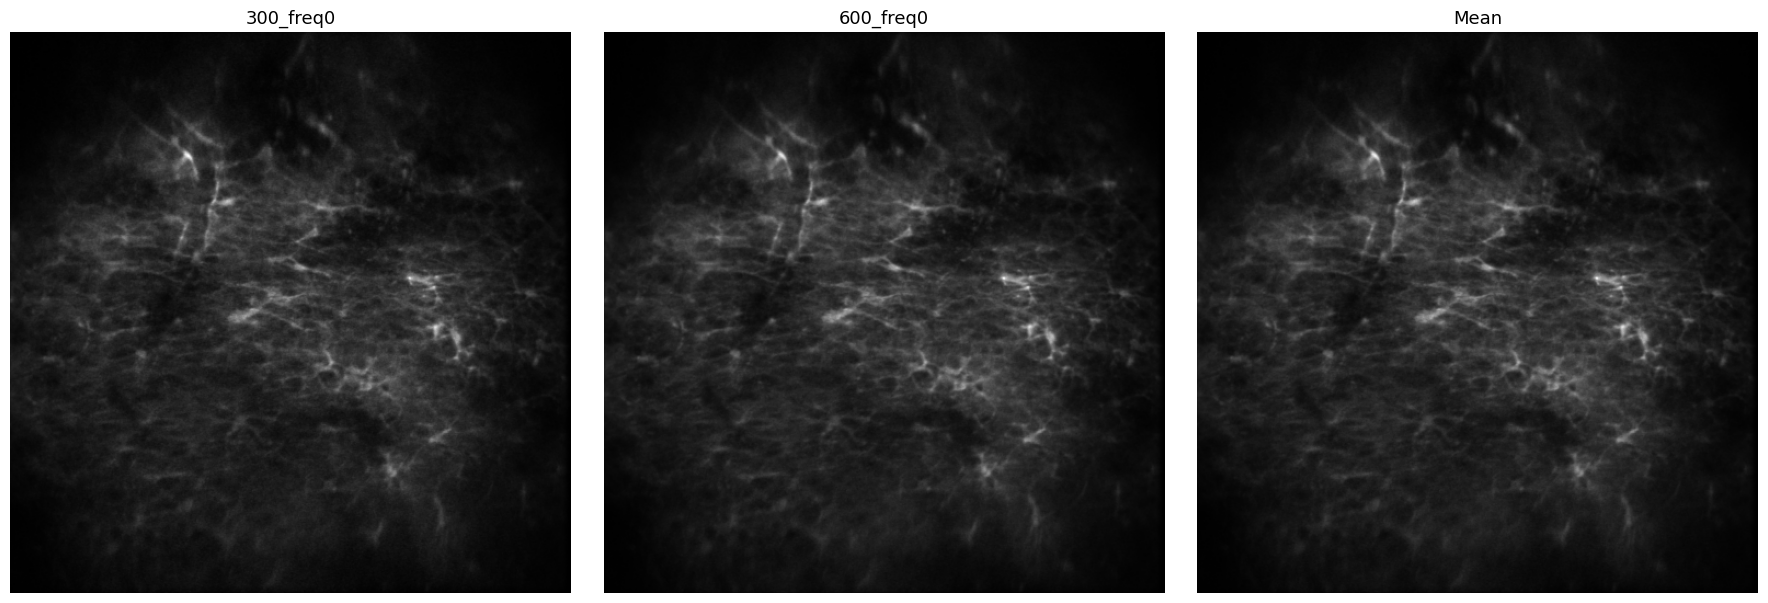

In [20]:
freq0s={file.stem:np.load(file) for file in Path("fft_freq0").glob("*.npy")}
mean=np.mean(np.stack(list(freq0s.values())), axis=0)
imshow({**freq0s, "Mean":mean}, size=6)